### Introduction
In this project we will create a model to analyze images of dogs and will output its guess of what breed it is.

We are using a dataset with 70 dog breeds with ~100 images per breed.

To create the model we used transfer learning with a variety of pretained models like: densenet, imagenet, ... then added new layers and fine tuning to make it work better for identifying dog breeds.

### Data Pre-Processing


In [1]:
# Import all the necessary modules

import os
import shutil
import tensorflow as tf
import keras
import pickle
import random
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorflow.keras.preprocessing import image as image_utils
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import Sequence

from tensorflow.keras.applications.densenet import decode_predictions

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


In [2]:
# Get the pre-trained DenseNet model

model = tf.keras.applications.densenet.DenseNet121(
    include_top=True, weights='imagenet')

2024-04-21 21:37:28.571642: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-21 21:37:29.294374: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78911 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:87:00.0, compute capability: 8.0


In [3]:
# Funtions to show the images, load and process them to the correct input shape and make a prediction

def show_image(image_path):
    image = mpimg.imread(image_path)
    print(image.shape)
    plt.imshow(image)
    
def load_and_process_image(image_path):
    # Print image's original shape, for reference
    print('Original image shape: ', mpimg.imread(image_path).shape)
    
    # Load in the image with a target size of 224, 224
    image = image_utils.load_img(image_path, target_size=(224, 224))
    # Convert the image from a PIL format to a numpy array
    image = image_utils.img_to_array(image)
    # Add a dimension for number of images, in our case 1
    image = image.reshape(1,224,224,3)
    # Preprocess image to align with original ImageNet dataset
    image = preprocess_input(image)
    # Print image's shape after processing
    print('Processed image shape: ', image.shape)
    return image

def densenet_prediction(image_path):
    # Show image
    show_image(image_path)
    # Load and pre-process image
    image = load_and_process_image(image_path)
    # Make predictions
    predictions = model.predict(image)
    # Print predictions in readable form
    print('Predicted:', decode_predictions(predictions, top=3))

(224, 224, 3)


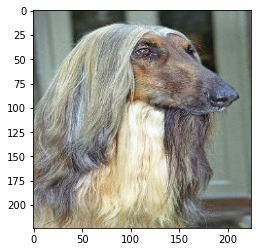

In [4]:
# Check that show_image works
show_image("test/Afghan/04.jpg")

In [5]:
processed_image = load_and_process_image("test/Afghan/04.jpg")

Original image shape:  (224, 224, 3)
Processed image shape:  (1, 224, 224, 3)


(224, 224, 3)
Original image shape:  (224, 224, 3)
Processed image shape:  (1, 224, 224, 3)


2024-04-21 21:37:39.128536: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201


Predicted: [[('n02085936', 'Maltese_dog', 0.83215106), ('n02098413', 'Lhasa', 0.084391564), ('n02098286', 'West_Highland_white_terrier', 0.018758198)]]


2024-04-21 21:37:41.201230: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


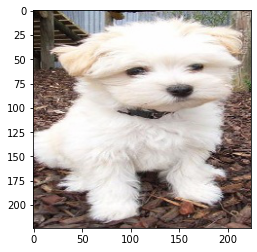

In [6]:
densenet_prediction("test/Maltese/04.jpg")

### Model setup

In [7]:
from tensorflow.keras.models import Model

num_classes = 70

# Define the base model (DenseNet121) without the top classification layer
base_model = tf.keras.applications.DenseNet121(
    include_top=False, weights='imagenet', input_shape=(224, 224, 3)
)

# Freeze the pre-trained layers
base_model.trainable = False

# Add a custom classification head
global_average_layer = GlobalAveragePooling2D()(base_model.output)
output_layer = Dense(num_classes, activation='softmax')(global_average_layer)

# Combine the base model with the custom classification head
model = Model(inputs=base_model.input, outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display a summary of the model architecture
#model.summary()


In [8]:
# Get current working directory
current_dir = os.getcwd()

# Define the directories for training, validation, and testing data
train_dir = os.path.join(current_dir, 'train')
valid_dir = os.path.join(current_dir, 'valid')
test_dir = os.path.join(current_dir, 'test')

# Define the ImageDataGenerator for training data
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    # Augmentation techniques
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Define the ImageDataGenerator for validation and testing data
valid_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Create data generators for training, validation, and testing data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'  # set as training data
)

validation_generator = valid_test_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)
test_generator = valid_test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 6396 images belonging to 70 classes.
Found 700 images belonging to 70 classes.
Found 717 images belonging to 70 classes.


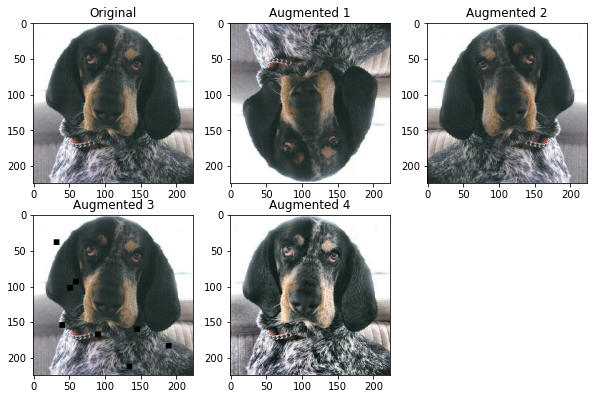

In [9]:
# pip install -U git+https://github.com/albumentations-team/albumentations

import albumentations as A  # Make sure to install albumentations package
# Display augmented images
# Load the image
image_path = "test/Bluetick/04.jpg"  # Replace with the path to your image
image = image_utils.load_img(image_path, target_size=(224, 224))
image = image_utils.img_to_array(image)

# Define augmentation techniques
augments = [
    A.VerticalFlip(p=1),
    A.HorizontalFlip(p=1),
    A.CoarseDropout(p=1),
    A.CLAHE(p=1)
]

# Plot the original image and augmented images
plt.figure(figsize=(10, 10))
plt.subplot(3, 3, 1)
plt.title('Original')
plt.imshow(image.astype(np.uint8))

# Apply each augmentation technique and plot the augmented image
for i, augment in enumerate(augments):
    augmented_img = augment(image=image.astype(np.uint8))['image']  # Ensure the image is uint8
    plt.subplot(3, 3, i + 2)
    plt.title(f'Augmented {i + 1}')
    plt.imshow(augmented_img.astype(np.uint8))
plt.show()


In [10]:
history = model.fit(
    train_generator,
    epochs=10,
    batch_size=32,
    validation_data=validation_generator
)

test_loss, test_accuracy = model.evaluate(test_generator)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Epoch 1/5
200/200 [==============================] - 62s 290ms/step - loss: 1.8126 - accuracy: 0.6094 - val_loss: 0.6669 - val_accuracy: 0.8829
Epoch 2/5
200/200 [==============================] - 57s 284ms/step - loss: 0.5211 - accuracy: 0.8801 - val_loss: 0.5036 - val_accuracy: 0.9143
Epoch 3/5
200/200 [==============================] - 57s 284ms/step - loss: 0.3729 - accuracy: 0.9043 - val_loss: 0.4865 - val_accuracy: 0.9171
Epoch 4/5
200/200 [==============================] - 57s 285ms/step - loss: 0.3001 - accuracy: 0.9212 - val_loss: 0.4542 - val_accuracy: 0.9300
Epoch 5/5
23/23 [==============================] - 2s 94ms/step - loss: 0.1509 - accuracy: 0.9554
Test Loss: 0.15089693665504456
Test Accuracy: 0.9553695917129517


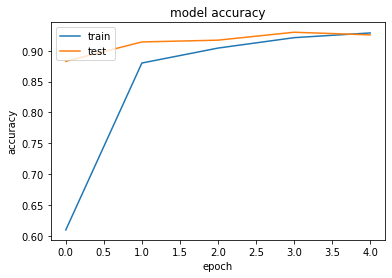

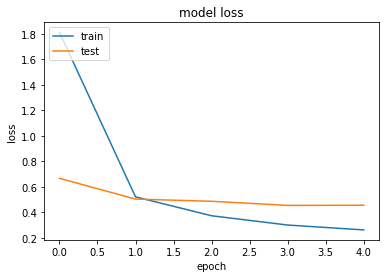

In [11]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

(224, 224, 3)
Original image shape:  (224, 224, 3)
Processed image shape:  (1, 224, 224, 3)
Predicted class: Borzoi, Probability: 0.9991379976272583
Predicted class: Greyhound, Probability: 0.0003667976998258382
Predicted class: Afghan, Probability: 0.0002102141734212637


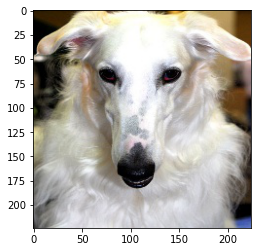

In [12]:
dog_species = [name for name in os.listdir('./test') if os.path.isdir(os.path.join('./test', name))]
dog_species.sort()
# print(dog_species)

def display_top_predictions(predictions, top=3):
    # Get the top predicted classes and corresponding probabilities
    top_indices = np.argsort(predictions)[0][-top:][::-1]
    top_probabilities = predictions[0][top_indices]
    
    # Print the top predictions
    for i in range(top):
        print(f"Predicted class: {dog_species[top_indices[i]]}, Probability: {top_probabilities[i]}")

        
def model_prediction(image_path):
    # Show image
    show_image(image_path)
    # Load and pre-process image
    image = load_and_process_image(image_path)
    # Make predictions
    predictions = model.predict(image)
    #Display top predictions
    display_top_predictions(predictions)
    
model_prediction("valid/Borzoi/01.jpg")

Found 700 images belonging to 70 classes.


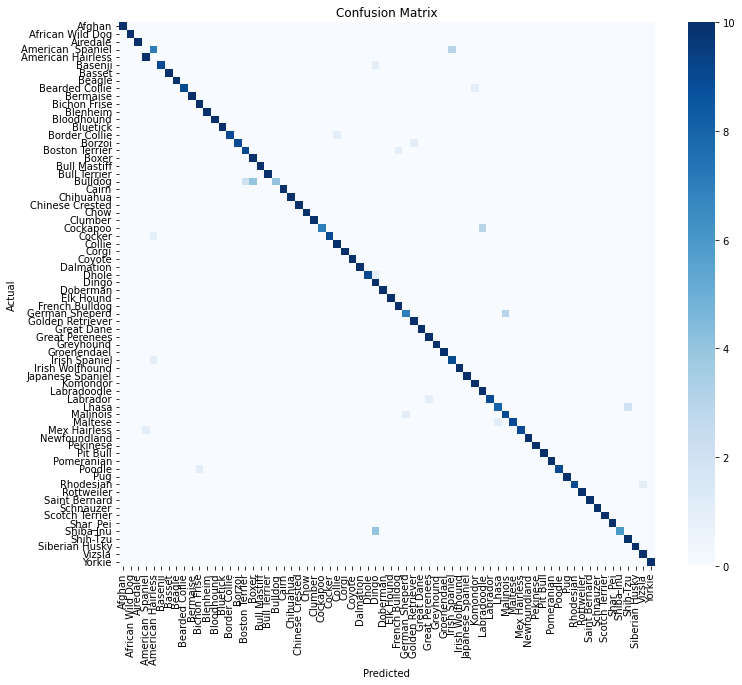

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Disable shuffling in the test generator
test_generator = valid_test_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Disable shuffling
)

# Predict classes for the test set
y_true = test_generator.classes

# Disable Dropout layers during inference
model.evaluate(test_generator, verbose=0)

# Predict classes for the test set again
y_pred = model.predict(test_generator).argmax(axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
# Input image dimensions, etc.
resized_height = 224
resized_width = 224
num_channel = 3
num_classes = 14
batch_size = 128

train_images = image_dataset_from_directory(
    './train', labels='inferred', label_mode='categorical',
     color_mode='rgb', batch_size=batch_size, image_size=(resized_height ,
    resized_width ), shuffle=False, seed=42,
    interpolation='bilinear', follow_links=False,
    crop_to_aspect_ratio=False)

valid_images = image_dataset_from_directory(
    './valid', labels='inferred', label_mode='categorical',
     color_mode='rgb', batch_size=batch_size, image_size=(resized_height ,
    resized_width ), shuffle=True, seed=42,
    interpolation='bilinear', follow_links=False,
    crop_to_aspect_ratio=False)

Found 7954 files belonging to 70 classes.
Found 700 files belonging to 70 classes.


In [14]:
y_test = []
for images, labels in valid_images:
    for i in range(len(labels)):
        index, = np.where(labels[i] == 1)
        y_test.append(index)

new_y_test = []
for i in range(0, 700):
    new_y_test.append(int(y_test[i][0]))        

#----------------------------------------------------------------------------------------

y_pred_proba = model.predict(valid_images)

# print(y_pred_proba)

for i in range(0, 700):
    max = y_pred_proba[i].max()
    index, = np.where(y_pred_proba[i] == max)
    # print(max)
    y_pred_proba[i] = index
    
    # max = 0
    # for j in range(0, 70):
    #     if y_pred_proba[i][j] > max:
    #         max = y_pred_proba[i][j]
    #         index = j
    # y_pred_proba[i] = index
    
new_y_pred_proba = []
for i in range(0, 700):
    new_y_pred_proba.append(int(y_pred_proba[i][0]))

       
# print(y_test)
# print(y_pred_proba)
print(new_y_test)
print(new_y_pred_proba)

# cm = confusion_matrix(new_y_test, new_y_pred_proba)
# ConfusionMatrixDisplay(cm).plot()
# print(classification_report(new_y_test, new_y_pred_proba))


[30, 56, 0, 68, 4, 0, 23, 14, 22, 10, 65, 24, 36, 51, 53, 19, 52, 49, 50, 45, 48, 19, 37, 60, 51, 24, 47, 9, 69, 58, 34, 21, 32, 61, 52, 8, 22, 14, 28, 52, 28, 0, 0, 30, 0, 12, 48, 44, 61, 40, 68, 13, 59, 43, 29, 10, 15, 65, 17, 7, 56, 6, 36, 26, 15, 22, 39, 54, 26, 69, 19, 46, 19, 30, 26, 9, 39, 12, 31, 40, 51, 51, 6, 6, 24, 62, 43, 27, 24, 33, 55, 29, 55, 46, 48, 5, 34, 43, 39, 21, 50, 44, 33, 31, 11, 36, 25, 18, 25, 24, 46, 62, 2, 0, 60, 0, 11, 48, 35, 66, 40, 15, 9, 46, 52, 47, 59, 47, 34, 23, 20, 47, 34, 49, 57, 37, 32, 39, 20, 42, 39, 2, 49, 46, 19, 13, 19, 31, 44, 65, 54, 3, 25, 10, 18, 60, 69, 60, 69, 64, 20, 52, 9, 16, 54, 2, 48, 11, 51, 40, 1, 57, 55, 69, 12, 21, 33, 20, 3, 28, 9, 45, 69, 57, 51, 7, 46, 43, 42, 14, 68, 20, 15, 68, 17, 24, 1, 2, 5, 54, 38, 61, 37, 34, 57, 42, 58, 1, 24, 17, 21, 1, 68, 29, 27, 40, 1, 48, 3, 11, 36, 29, 67, 60, 13, 67, 66, 36, 67, 10, 5, 59, 19, 40, 11, 56, 2, 44, 61, 5, 52, 20, 41, 27, 68, 32, 39, 62, 5, 2, 32, 57, 25, 24, 56, 18, 10, 1, 59, 26

### Hyperparameter tuning

### Results

### Discussion